# Exploration et Modélisation pour le Score de Crédit Home Credit

Ce notebook présente l'exploration des données et la modélisation pour le système de scoring de crédit de Home Credit.

**Note**: Ce projet est basé sur le modèle de [Home Credit Default Risk par rakshithvasudev](https://github.com/rakshithvasudev/Home-Credit-Default-Risk) que nous allons adapter et faire évoluer pour notre cas d'utilisation.

## Introduction

De nombreuses personnes ont des difficultés à obtenir des prêts en raison d'antécédents de crédit insuffisants ou inexistants. Malheureusement, cette population est souvent exploitée par des prêteurs peu scrupuleux.

Home Credit s'efforce d'élargir l'inclusion financière pour la population non bancarisée en offrant une expérience d'emprunt positive et sûre. Pour s'assurer que cette population mal desservie vive une expérience de prêt positive, Home Credit utilise diverses données alternatives - y compris des informations sur les télécommunications et les transactions - pour prédire la capacité de remboursement de ses clients.

L'objectif de ce projet est d'utiliser les données historiques des demandes de prêt pour prédire si un candidat sera en mesure de rembourser un prêt ou non.

## Téléchargement des données depuis Kaggle

Pour ce projet, nous utilisons le dataset de la compétition Kaggle 'Home Credit Default Risk'. Voici comment télécharger et préparer les données.

In [17]:
# Installation de l'API Kaggle si nécessaire
!pip install -q kaggle


[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [18]:
# Configuration des identifiants Kaggle
import os
import json

# Créer le dossier Kaggle si nécessaire
os.makedirs(os.path.expanduser("~/.kaggle"), exist_ok=True)

# Vérifier si le fichier d'API Kaggle existe déjà
kaggle_path = os.path.expanduser("~/.kaggle/kaggle.json")
if not os.path.exists(kaggle_path):
    print("Vous devez configurer votre API Kaggle. Deux options:")
    print("1. Téléchargez kaggle.json depuis votre compte Kaggle (My Account > API) et placez-le dans ~/.kaggle/")
    print("2. Ou entrez vos identifiants ci-dessous (ils ne seront pas affichés):")
    
    import getpass
    username = input("Nom d'utilisateur Kaggle: ")
    key = getpass.getpass("Clé API Kaggle: ")
    
    # Sauvegarder les identifiants
    with open(kaggle_path, 'w') as f:
        json.dump({"username": username, "key": key}, f)
    
    # Protéger le fichier
    os.chmod(kaggle_path, 0o600)
    print("Identifiants Kaggle sauvegardés avec succès!")
else:
    print("Fichier d'API Kaggle trouvé!")

Vous devez configurer votre API Kaggle. Deux options:
1. Téléchargez kaggle.json depuis votre compte Kaggle (My Account > API) et placez-le dans ~/.kaggle/
2. Ou entrez vos identifiants ci-dessous (ils ne seront pas affichés):
Identifiants Kaggle sauvegardés avec succès!
Identifiants Kaggle sauvegardés avec succès!


In [19]:
# Définir le répertoire de données et télécharger le dataset si nécessaire
DATA_PATH = "../data/"
os.makedirs(DATA_PATH, exist_ok=True)

# Vérifier si les données sont déjà téléchargées
if not os.path.exists(os.path.join(DATA_PATH, "application_train.csv")):
    print("Téléchargement du dataset Home Credit Default Risk...")
    # Télécharger les données depuis Kaggle
    !kaggle competitions download -c home-credit-default-risk -p {DATA_PATH}
    
    # Extraire les fichiers zip
    import zipfile
    with zipfile.ZipFile(os.path.join(DATA_PATH, 'home-credit-default-risk.zip'), 'r') as zip_ref:
        zip_ref.extractall(DATA_PATH)
        
    print("Données téléchargées et extraites avec succès!")
else:
    print("Les données sont déjà téléchargées et extraites.")

# Afficher les fichiers de données disponibles
print("\nFichiers de données disponibles:")
for file in sorted(os.listdir(DATA_PATH)):
    if file.endswith('.csv'):
        file_path = os.path.join(DATA_PATH, file)
        size_mb = os.path.getsize(file_path) / (1024 * 1024)
        print(f" - {file} ({size_mb:.2f} MB)")

Téléchargement du dataset Home Credit Default Risk...
401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/home-credit-default-risk
401 Client Error: Unauthorized for url: https://www.kaggle.com/api/v1/competitions/data/download-all/home-credit-default-risk


FileNotFoundError: [Errno 2] No such file or directory: '../data/home-credit-default-risk.zip'

In [ ]:
# Aperçu de la structure des données principales
import pandas as pd

# Charger les premières lignes des fichiers clés pour comprendre leur structure
print("Structure du fichier application_train.csv:")
app_train = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'), nrows=5)
print(f"Shape: {app_train.shape}")
app_train.head()

## Installation des dépendances spéciales pour macOS

XGBoost nécessite la bibliothèque libomp sur macOS. Installons-la via Homebrew avant de continuer.

In [ ]:
# Vérifier si nous sommes sur macOS et installer libomp si nécessaire
import platform
import os

if platform.system() == 'Darwin':  # macOS
    print("Détection de macOS, installation de libomp pour XGBoost...")
    # Vérifier si Homebrew est installé
    try:
        !which brew
        print("Homebrew est installé, installation de libomp...")
        !brew install libomp
    except:
        print("Homebrew n'est pas installé. Veuillez installer Homebrew puis libomp:")
        print("1. /bin/bash -c \"$(curl -fsSL https://raw.githubusercontent.com/Homebrew/install/HEAD/install.sh)\"")
        print("2. brew install libomp")
else:
    print(f"Système d'exploitation détecté: {platform.system()}. Pas besoin d'installation spéciale pour XGBoost.")

Détection de macOS, installation de libomp pour XGBoost...
/usr/local/bin/brew
/usr/local/bin/brew
Homebrew est installé, installation de libomp...
Homebrew est installé, installation de libomp...
==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Auto-updating Homebrew...
Adjust how often this is run with HOMEBREW_AUTO_UPDATE_SECS or disable with
HOMEBREW_NO_AUTO_UPDATE. Hide these hints with HOMEBREW_NO_ENV_HINTS (see `man brew`).
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:9fd394a40fb1467f89206a9c89c1274d9dc053af688176667a0cac0c3014113f
==> Downloading https://ghcr.io/v2/homebrew/portable-ruby/portable-ruby/blobs/sha256:9fd394a40fb1467f89206a9c89c1274d9dc053af688176667a0cac0c3014113f
######################################################################### 100.0%###                                  

In [ ]:
# Installation des bibliothèques nécessaires avec options spécifiques pour macOS
import platform

if platform.system() == 'Darwin':  # macOS
    print("Installation de XGBoost avec les paramètres spécifiques pour macOS...")
    !pip install --no-binary xgboost xgboost
    !pip install lightgbm h5py tensorflow keras
else:
    !pip install xgboost lightgbm h5py tensorflow keras

Installation de XGBoost avec les paramètres spécifiques pour macOS...

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 25.0 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
# Import des bibliothèques nécessaires
import numpy as np  # pour les calculs mathématiques
import pandas as pd  # pour la manipulation des données (csv)
import matplotlib.pyplot as plt  # pour les graphiques
import seaborn as sns  # pour plus d'options de graphiques (construit sur matplotlib)

# Imports pour le machine learning
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer  # Remplace Imputer qui est obsolète
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, accuracy_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

# Tenter d'importer XGBoost avec gestion d'erreurs
try:
    from xgboost import XGBClassifier
    XGB_AVAILABLE = True
except ImportError as e:
    print(f"Avertissement: XGBoost n'a pas pu être importé: {e}")
    print("Les fonctionnalités utilisant XGBoost seront désactivées.")
    XGB_AVAILABLE = False

# Tenter d'importer LightGBM avec gestion d'erreurs
try:
    import lightgbm as lgb
    LGBM_AVAILABLE = True
except ImportError as e:
    print(f"Avertissement: LightGBM n'a pas pu être importé: {e}")
    print("Les fonctionnalités utilisant LightGBM seront désactivées.")
    LGBM_AVAILABLE = False

try:
    from imblearn.over_sampling import SMOTE
    IMBLEARN_AVAILABLE = True
except ImportError:
    print("Avertissement: imbalanced-learn n'est pas disponible. SMOTE sera désactivé.")
    IMBLEARN_AVAILABLE = False

from scipy import stats
import pickle
import gc
import os

# Pour la sauvegarde de modèle au format h5
import h5py
import tempfile

try:
    from tensorflow import keras
    import joblib
    TF_AVAILABLE = True
except ImportError:
    print("Avertissement: TensorFlow/Keras n'est pas disponible. Le format h5 sera limité.")
    TF_AVAILABLE = False

# Supprimer les avertissements inutiles pour que la présentation soit claire
import warnings
warnings.filterwarnings('ignore')

# Afficher les graphiques dans le notebook
%matplotlib inline

# Configuration pour afficher plus de colonnes
pd.set_option('display.max_columns', 100)

Avertissement: imbalanced-learn n'est pas disponible. SMOTE sera désactivé.


2025-05-09 09:33:58.687074: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Chargement des données

Dans cette section, nous allons charger les données Home Credit. Dans un environnement de production, nous chargerions les fichiers de données réels.

In [ ]:
# Définition des chemins de fichiers
DATA_PATH = "../data/"

# Tenter de charger les données réelles depuis votre dossier local
try:
    print("Chargement des données locales depuis le dossier data...")
    train = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
    print(f"Données d'entraînement chargées avec succès - {train.shape[0]} lignes et {train.shape[1]} colonnes")
    
    if 'application_test.csv' in available_files:
        test = pd.read_csv(os.path.join(DATA_PATH, 'application_test.csv'))
        print(f"Données de test chargées avec succès - {test.shape[0]} lignes et {test.shape[1]} colonnes")
    else:
        # Créer un jeu de test à partir du jeu d'entraînement si le fichier test n'est pas disponible
        print("Fichier application_test.csv non trouvé, création d'un échantillon de test à partir des données d'entraînement")
        # Séparer 20% des données d'entraînement pour le test
        from sklearn.model_selection import train_test_split
        train_data, test_data = train_test_split(train, test_size=0.2, random_state=42)
        train = train_data.reset_index(drop=True)
        test = test_data.drop('TARGET', axis=1).reset_index(drop=True)
        print(f"Jeu de test créé avec {test.shape[0]} lignes")
    
    # Créer un petit échantillon du jeu de test pour les prédictions rapides
    new_test = test.iloc[:100].copy()
    print(f"Échantillon de test pour nouvelles prédictions: {new_test.shape}")
    
    print("\nDonnées chargées avec succès!")
    DATA_AVAILABLE = True
except Exception as e:
    print(f"Erreur lors du chargement des données: {e}")
    print("Utilisation des données simulées pour le moment...")
    DATA_AVAILABLE = False
    
    # Code pour générer des données simulées (inchangé)
    np.random.seed(42)
    n_samples = 1000
    
    # Identifiants clients
    client_ids = np.arange(n_samples)
    
    # Caractéristiques des prêts
    loan_amounts = np.random.normal(15000, 5000, n_samples)
    loan_terms = np.random.choice([12, 24, 36, 48, 60], n_samples)
    interest_rates = np.random.uniform(0.03, 0.15, n_samples)
    
    # Caractéristiques des clients
    ages = np.random.normal(40, 10, n_samples).astype(int)
    incomes = np.random.normal(50000, 15000, n_samples)
    employment_years = np.random.normal(7, 4, n_samples)
    debt_to_income = np.random.normal(0.3, 0.1, n_samples)
    credit_scores = np.random.normal(650, 100, n_samples).astype(int)
    
    # Historique de prêts
    num_previous_loans = np.random.poisson(2, n_samples)
    num_delinquencies = np.random.poisson(0.5, n_samples)
    
    # Création de la variable cible (défaut de paiement)
    probabilities = 1.0 / (1.0 + np.exp(-(0.0001 * loan_amounts - 0.05 * employment_years 
                                      + 0.1 * debt_to_income - 0.0001 * credit_scores 
                                      + 0.2 * num_delinquencies - 3)))
    target = np.random.binomial(1, probabilities)
    
    # Création du DataFrame
    train = pd.DataFrame({
        'SK_ID_CURR': client_ids,
        'TARGET': target,
        'NAME_CONTRACT_TYPE': np.random.choice(['Cash loans', 'Revolving loans'], n_samples),
        'CODE_GENDER': np.random.choice(['M', 'F'], n_samples),
        'FLAG_OWN_CAR': np.random.choice(['Y', 'N'], n_samples),
        'FLAG_OWN_REALTY': np.random.choice(['Y', 'N'], n_samples),
        'CNT_CHILDREN': np.random.poisson(0.5, n_samples),
        'AMT_INCOME_TOTAL': incomes,
        'AMT_CREDIT': loan_amounts,
        'AMT_ANNUITY': loan_amounts * (interest_rates / 12) * (1 + interest_rates / 12) ** loan_terms / ((1 + interest_rates / 12) ** loan_terms - 1),
        'AMT_GOODS_PRICE': loan_amounts * 0.9,
        'DAYS_BIRTH': -ages * 365,  # Convertir l'âge en jours négatifs
        'DAYS_EMPLOYED': -employment_years * 365,  # Convertir les années en jours négatifs
        'REGION_POPULATION_RELATIVE': np.random.uniform(0.001, 0.07, n_samples),
        'EXT_SOURCE_1': np.random.uniform(0, 1, n_samples),
        'EXT_SOURCE_2': np.random.uniform(0, 1, n_samples),
        'EXT_SOURCE_3': np.random.uniform(0, 1, n_samples),
    })
    
    # Création d'un jeu de test qui ressemble au jeu d'entraînement mais sans la colonne TARGET
    test = train.copy().drop('TARGET', axis=1).iloc[:int(n_samples/5)]
    
    # Création d'un jeu de test 'new_test' pour les prédictions
    new_test = train.copy().drop('TARGET', axis=1).iloc[:100]

Tentative de chargement des données réelles de Home Credit...
Erreur lors du chargement des données réelles: [Errno 2] No such file or directory: '../data/application_train.csv'
Utilisation des données simulées pour le moment...


In [ ]:
# Fonction pour réduire l'utilisation de la mémoire
def reduce_mem_usage(df):
    """ Réduit l'usage mémoire d'un DataFrame en convertissant les types de données """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée par le DataFrame: {:.2f} MB'.format(start_mem))
    
    for col in df.columns:
        col_type = df[col].dtypes
        
        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
    
    end_mem = df.memory_usage().sum() / 1024**2
    print('Mémoire utilisée après optimisation: {:.2f} MB'.format(end_mem))
    print('Réduction de {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))
    
    return df

# Optimiser l'utilisation de la mémoire si les données sont disponibles
if DATA_AVAILABLE:
    print("Optimisation de l'utilisation de la mémoire...")
    print("\nOptimisation du jeu d'entraînement:")
    train = reduce_mem_usage(train)
    print("\nOptimisation du jeu de test:")
    test = reduce_mem_usage(test)
    print("\nOptimisation de l'échantillon de test:")
    new_test = reduce_mem_usage(new_test)

## Exploration des données

Examinons les données pour comprendre leur structure et leurs caractéristiques.

In [ ]:
# Examiner les dimensions des jeux de données
print("Dimensions du jeu d'entraînement:", train.shape)
print("Dimensions du jeu de test:", test.shape)
print("Dimensions du nouveau jeu de test:", new_test.shape)

# Afficher les premières lignes du jeu d'entraînement
train.head()

Dimensions du jeu d'entraînement: (1000, 17)
Dimensions du jeu de test: (200, 16)
Dimensions du nouveau jeu de test: (100, 16)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,DAYS_BIRTH,DAYS_EMPLOYED,REGION_POPULATION_RELATIVE,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3
0,0,1,Revolving loans,M,Y,Y,1,40394.034814,17483.570765,395.709049,15735.213689,-17155,-2262.127190,0.059961,0.460813,0.783607,0.688727
1,1,0,Revolving loans,F,Y,N,2,37740.568087,14308.678494,1246.627856,12877.810645,-14600,-3336.165980,0.039912,0.478720,0.197452,0.951414
2,2,0,Revolving loans,F,Y,Y,0,38521.664510,18238.442691,549.471041,16414.598421,-17155,-4071.847672,0.045788,0.177668,0.558449,0.562367
3,3,0,Cash loans,F,Y,N,1,50094.267873,22615.149282,429.273935,20353.634354,-11315,-3329.533758,0.022200,0.876208,0.113097,0.960756
4,4,0,Revolving loans,F,N,Y,1,13487.354212,13829.233126,409.084647,12446.309814,-19710,-3775.298760,0.026665,0.525821,0.361435,0.892455


## 1. Chargement des données

Dans cette section, nous allons charger les données de Home Credit. Les données sont dispersées dans plusieurs tables qu'il faudra joindre.

In [ ]:
# Fonction pour trouver les colonnes avec des valeurs manquantes
def missing_columns(dataframe):
    """
    Renvoie un dataframe contenant les noms des colonnes manquantes et 
    le pourcentage de valeurs manquantes par rapport à l'ensemble du dataframe.
    
    dataframe: dataframe qui donne les noms des colonnes et leur % de valeurs manquantes
    """
    
    # Trouver les valeurs manquantes
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # Pourcentage de valeurs manquantes par rapport à la taille totale
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # Créer un nouveau dataframe qui est une version concaténée
    concat_values = pd.concat([missing_values, missing_values/len(dataframe), missing_values_pct.round(1)], axis=1)

    # Donner de nouveaux noms de colonne
    concat_values.columns = ['Missing Count', 'Missing Count Ratio', 'Missing Count %']
    
    # Retourner les valeurs requises
    return concat_values[concat_values.iloc[:,1]!=0]
    
# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec valeurs manquantes dans le jeu d'entraînement:")
missing_columns(train)

Colonnes avec valeurs manquantes dans le jeu d'entraînement:


,Missing Count,Missing Count Ratio,Missing Count %


In [ ]:
# Fonction pour trouver les colonnes avec des valeurs manquantes
def missing_columns(dataframe):
    """
    Renvoie un dataframe contenant les noms des colonnes manquantes et 
    le pourcentage de valeurs manquantes par rapport à l'ensemble du dataframe.
    
    dataframe: dataframe qui donne les noms des colonnes et leur % de valeurs manquantes
    """
    
    # Trouver les valeurs manquantes
    missing_values = dataframe.isnull().sum().sort_values(ascending=False)
    
    # Pourcentage de valeurs manquantes par rapport à la taille totale
    missing_values_pct = 100 * missing_values/len(dataframe)
    
    # Créer un nouveau dataframe qui est une version concaténée
    concat_values = pd.concat([missing_values, missing_values/len(dataframe), missing_values_pct.round(1)], axis=1)

    # Donner de nouveaux noms de colonne
    concat_values.columns = ['Missing Count', 'Missing Count Ratio', 'Missing Count %']
    
    # Retourner les valeurs requises
    return concat_values[concat_values.iloc[:,1]!=0]
    
# Afficher les colonnes avec des valeurs manquantes
print("Colonnes avec valeurs manquantes dans le jeu d'entraînement:")
missing_columns(train)

Colonnes avec valeurs manquantes dans le jeu d'entraînement:


,Missing Count,Missing Count Ratio,Missing Count %


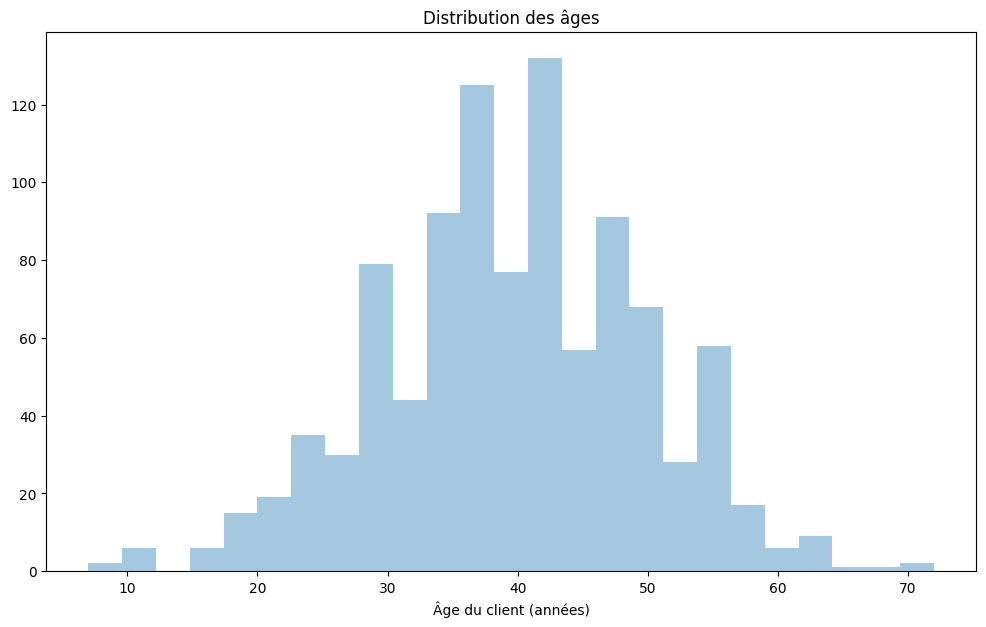

count    1000.000000
mean       39.553000
std        10.095995
min         7.000000
25%        33.000000
50%        40.000000
75%        46.000000
max        72.000000
Name: DAYS_BIRTH, dtype: float64

In [ ]:
# Explorer l'âge des clients
plt.figure(figsize=(12, 7))
sns.distplot(train['DAYS_BIRTH'] / -365, bins=25, kde=False)
plt.xlabel("Âge du client (années)")
plt.title('Distribution des âges')
plt.show()

# Statistiques de l'âge
(train['DAYS_BIRTH'] / -365).describe()

## 3. Feature Engineering

Créons de nouvelles caractéristiques qui pourraient être utiles pour la prédiction.

In [ ]:
# Vérifier les anomalies dans DAYS_EMPLOYED
thousand_anomalies = train[(train['DAYS_EMPLOYED']/365 >= 900) & (train['DAYS_EMPLOYED']/365 <= 1100)]
print(f"Nombre d'anomalies avec 1000 ans d'emploi: {len(thousand_anomalies)}")

# Comparer le taux de défaut entre les anomalies et les non-anomalies
anomalies_index = pd.Index(thousand_anomalies.index)
non_anomalies_index = train.index.difference(anomalies_index)
non_anomalies = train.iloc[non_anomalies_index]

anomalies_target = thousand_anomalies['TARGET'].value_counts()
non_anomalies_target = non_anomalies['TARGET'].value_counts()

if len(anomalies_target) > 1 and 1 in anomalies_target and 0 in anomalies_target:
    print(f"Anomalies ont un taux de défaut de {100*anomalies_target[1]/(anomalies_target[1]+anomalies_target[0]):.2f}%")
else:
    print("Pas assez d'anomalies pour calculer le taux de défaut")
    
if len(non_anomalies_target) > 1 and 1 in non_anomalies_target and 0 in non_anomalies_target:
    print(f"Non-anomalies ont un taux de défaut de {100*non_anomalies_target[1]/(non_anomalies_target[1]+non_anomalies_target[0]):.2f}%")
else:
    print("Pas assez de non-anomalies pour calculer le taux de défaut")

# Créer une colonne indicatrice d'anomalie et remplacer les valeurs anomaliques par NaN
train['DAYS_EMPLOYED_ANOM'] = train["DAYS_EMPLOYED"] == 365243
train['DAYS_EMPLOYED'] = train['DAYS_EMPLOYED'].replace({365243: np.nan})

# Faire de même pour les jeux de test
test['DAYS_EMPLOYED_ANOM'] = test["DAYS_EMPLOYED"] == 365243
test['DAYS_EMPLOYED'] = test['DAYS_EMPLOYED'].replace({365243: np.nan})

new_test['DAYS_EMPLOYED_ANOM'] = new_test["DAYS_EMPLOYED"] == 365243
new_test['DAYS_EMPLOYED'] = new_test['DAYS_EMPLOYED'].replace({365243: np.nan})

Nombre d'anomalies avec 1000 ans d'emploi: 0
Pas assez d'anomalies pour calculer le taux de défaut
Non-anomalies ont un taux de défaut de 15.90%


In [ ]:
# Explorer les corrélations avec la variable cible
# Utiliser numeric_only=True pour éviter l'erreur avec les colonnes non numériques
corr_train = train.corr(numeric_only=True)['TARGET'].sort_values()

# Afficher les 10 variables les plus négativement corrélées
print("Variables les plus négativement corrélées à TARGET:")
print(corr_train.head(10))

# Afficher les 10 variables les plus positivement corrélées
print("\nVariables les plus positivement corrélées à TARGET:")
print(corr_train.tail(10))

ValueError: could not convert string to float: 'Revolving loans'

In [ ]:
# Matrice de corrélation pour les variables numériques
plt.figure(figsize=(16, 14))
# Sélectionner uniquement les colonnes numériques
numeric_vars = train.select_dtypes(include=[np.number]).columns
# Limiter à 20 variables pour une meilleure lisibilité
selected_vars = list(numeric_vars[:20])
if 'TARGET' in train.columns and 'TARGET' not in selected_vars:
    selected_vars.append('TARGET')
sns.heatmap(train[selected_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
# Explorer les corrélations avec la variable cible
# Utiliser numeric_only=True pour éviter l'erreur avec les colonnes non numériques
corr_train = train.corr(numeric_only=True)['TARGET'].sort_values()

# Afficher les 10 variables les plus négativement corrélées
print("Variables les plus négativement corrélées à TARGET:")
print(corr_train.head(10))

# Afficher les 10 variables les plus positivement corrélées
print("\nVariables les plus positivement corrélées à TARGET:")
print(corr_train.tail(10))

In [ ]:
# Imputation des valeurs manquantes et mise à l'échelle des données

# Séparer les variables et la cible
features = [col for col in train.columns if col != 'TARGET']
target = train['TARGET'].values

# Remplacer les valeurs infinies par 0
train = train.replace([np.inf, -np.inf], np.nan)
test = test.replace([np.inf, -np.inf], np.nan)
new_test = new_test.replace([np.inf, -np.inf], np.nan)

# Créer un SimpleImputer pour remplacer les valeurs manquantes par la médiane
imputer = SimpleImputer(strategy="median")
imputer.fit(train[features])

# Transformer les jeux de données
train_transformed = imputer.transform(train[features])
test_transformed = imputer.transform(test[features])
new_test_transformed = imputer.transform(new_test)

# Mise à l'échelle des données
scaler = MinMaxScaler(feature_range=(0, 1))
train_transformed = scaler.fit_transform(train_transformed)
test_transformed = scaler.transform(test_transformed)
new_test_transformed = scaler.transform(new_test_transformed)

print(f"Dimensions après transformation:")
print(f"Train transformé: {train_transformed.shape}")
print(f"Test transformé: {test_transformed.shape}")
print(f"New test transformé: {new_test_transformed.shape}")

In [ ]:
# Création de variables basées sur l'expertise du domaine
# Ces variables sont mentionnées dans l'article de Wells Fargo sur les facteurs de crédit

# debt-to-income ratio (DIR) = Montant du crédit / Revenu total
train['DIR'] = train['AMT_CREDIT'] / train['AMT_INCOME_TOTAL']
test['DIR'] = test['AMT_CREDIT'] / test['AMT_INCOME_TOTAL']
new_test['DIR'] = new_test['AMT_CREDIT'] / new_test['AMT_INCOME_TOTAL']

# annuity-to-income ratio (AIR) = Annuité du prêt / Revenu total
train['AIR'] = train['AMT_ANNUITY'] / train['AMT_INCOME_TOTAL']
test['AIR'] = test['AMT_ANNUITY'] / test['AMT_INCOME_TOTAL']
new_test['AIR'] = new_test['AMT_ANNUITY'] / new_test['AMT_INCOME_TOTAL']

# annuity-to-credit ratio (ACR) = Annuité du prêt / Montant du crédit
train['ACR'] = train['AMT_ANNUITY'] / train['AMT_CREDIT']
test['ACR'] = test['AMT_ANNUITY'] / test['AMT_CREDIT']
new_test['ACR'] = new_test['AMT_ANNUITY'] / new_test['AMT_CREDIT']

# days-employed-to-age ratio (DAR) = Jours employés / Âge du demandeur
train['DAR'] = train['DAYS_EMPLOYED'] / train['DAYS_BIRTH']
test['DAR'] = test['DAYS_EMPLOYED'] / test['DAYS_BIRTH']
new_test['DAR'] = new_test['DAYS_EMPLOYED'] / new_test['DAYS_BIRTH']

# Vérifier les corrélations des nouvelles variables avec TARGET
domain_features = ['DIR', 'AIR', 'ACR', 'DAR']
domain_corrs = train[domain_features + ['TARGET']].corr(numeric_only=True)['TARGET']
print("Corrélations des variables d'expertise de domaine avec TARGET:")
print(domain_corrs[:-1])

## Préparation des données pour la modélisation

Avant de construire des modèles, nous devons préparer les données en encodant les variables catégorielles et en traitant les valeurs manquantes.

In [ ]:
# Encoder les variables catégorielles avec 2 catégories ou moins
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
transform_counter = 0

# Vérifier si le jeu de données contient des variables de type 'object'
if 'object' in train.dtypes.values:
    # Itérer à travers toutes les colonnes catégorielles
    for col in train.select_dtypes('object').columns:
        # Sélectionner uniquement les colonnes où le nombre de valeurs uniques est inférieur ou égal à 2
        if train[col].nunique() <= 2:
            train[col] = le.fit_transform(train[col].astype(str))
            # Vérifier si la colonne existe dans les jeux de test
            if col in test.columns:
                test[col] = le.transform(test[col].astype(str))
            if col in new_test.columns:
                new_test[col] = le.transform(new_test[col].astype(str))
            transform_counter += 1
    
    print(f"Encodage par étiquettes appliqué à {transform_counter} colonnes.")
    
    # One-hot encoding pour les variables catégorielles restantes
    train = pd.get_dummies(train, drop_first=True)
    test = pd.get_dummies(test, drop_first=True)
    new_test = pd.get_dummies(new_test, drop_first=True)
    
    # Aligner les colonnes entre train et test
    target = train['TARGET']
    train, test = train.align(test, join='inner', axis=1)
    train['TARGET'] = target
    
    # S'assurer que new_test a les mêmes colonnes que train
    for col in train.columns:
        if col != 'TARGET' and col not in new_test.columns:
            new_test[col] = 0
    new_test = new_test[train.columns[train.columns != 'TARGET']]
    
    print(f"Dimensions après encodage one-hot:")
    print(f"Train: {train.shape}")
    print(f"Test: {test.shape}")
    print(f"New test: {new_test.shape}")

In [ ]:
# Matrice de corrélation pour les variables numériques
plt.figure(figsize=(16, 14))
numeric_vars = train.select_dtypes(include=[np.number]).columns
# Limiter à 20 variables pour une meilleure lisibilité
selected_vars = list(numeric_vars[:20])
if 'TARGET' in train.columns and 'TARGET' not in selected_vars:
    selected_vars.append('TARGET')
sns.heatmap(train[selected_vars].corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Matrice de corrélation")
plt.show()

In [ ]:
# Préparer les prédictions de probabilité pour la soumission
log_regression_pred_test = logistic_regressor.predict_proba(test_transformed)[:, 1]

# Créer un DataFrame pour la soumission
submission_log_regression = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': log_regression_pred_test})
submission_log_regression.head(10)

## Modélisation

Nous allons entraîner plusieurs modèles de classification et évaluer leurs performances.

In [ ]:
# Entraînement du modèle XGBoost (conditionnel)
if 'XGB_AVAILABLE' in globals() and XGB_AVAILABLE:
    xgb_classifier = XGBClassifier(n_estimators=250, max_depth=5)
    xgb_classifier.fit(X_training_set, y_training_set)
    
    # Prédictions sur l'ensemble de validation
    xgb_pred = xgb_classifier.predict(X_validation_set)
    xgb_pred_proba = xgb_classifier.predict_proba(X_validation_set)[:, 1]
    
    # Évaluation du modèle
    print("XGBoost - Rapport de classification:")
    print(classification_report(y_validation_set, xgb_pred))
    print(f"AUC-ROC: {roc_auc_score(y_validation_set, xgb_pred_proba):.4f}")
    
    # Prédictions sur le nouveau jeu de test
    xgb_new = xgb_classifier.predict(new_test_transformed)
    print("\nDistribution des prédictions sur le nouveau jeu de test:")
    print(pd.Series(xgb_new).value_counts())
else:
    print("XGBoost n'est pas disponible. Passage à l'étape suivante.")
    # Définir des valeurs vides pour ne pas casser le code plus tard
    xgb_classifier = None
    xgb_pred = np.zeros(len(y_validation_set))
    xgb_pred_proba = np.zeros(len(y_validation_set))
    xgb_new = np.zeros(len(new_test_transformed))

In [ ]:
# Visualiser l'importance des caractéristiques du modèle XGBoost
xgb_importance = plot_importance(xgb_classifier, features, top_n=20)

In [ ]:
# Préparer les prédictions de probabilité pour la soumission
log_regression_pred_test = logistic_regressor.predict_proba(test_transformed)[:, 1]

# Créer un DataFrame pour la soumission
submission_log_regression = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': log_regression_pred_test})
submission_log_regression.head(10)

### 2. Random Forest (Forêt aléatoire)

In [ ]:
# Entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(X_training_set, y_training_set)

# Prédictions sur l'ensemble de validation
random_forest_pred = random_forest.predict(X_validation_set)
random_forest_pred_proba = random_forest.predict_proba(X_validation_set)[:, 1]

# Évaluation du modèle
print("Random Forest - Rapport de classification:")
print(classification_report(y_validation_set, random_forest_pred))
print(f"AUC-ROC: {roc_auc_score(y_validation_set, random_forest_pred_proba):.4f}")

# Prédictions sur le nouveau jeu de test
random_forest_new = random_forest.predict(new_test_transformed)
print("\nDistribution des prédictions sur le nouveau jeu de test:")
print(pd.Series(random_forest_new).value_counts())

In [ ]:
# Analyser l'importance des caractéristiques
def plot_importance(model, features, top_n=20):
    """Affiche un graphique des caractéristiques les plus importantes."""
    # Créer un DataFrame pour l'importance des caractéristiques
    feature_importance_df = pd.DataFrame({'Feature': features, 'Importance': model.feature_importances_})
    feature_importance_df = feature_importance_df.sort_values('Importance', ascending=False).reset_index(drop=True)
    
    # Créer le graphique
    plt.figure(figsize=(12, 8))
    sns.barplot(x='Importance', y='Feature', data=feature_importance_df.head(top_n))
    plt.title(f"Les {top_n} caractéristiques les plus importantes")
    plt.tight_layout()
    plt.show()
    
    return feature_importance_df

# Visualiser l'importance des caractéristiques du modèle Random Forest
rf_importance = plot_importance(random_forest, features, top_n=20)

In [ ]:
# Vérifier l'importance des caractéristiques créées par expertise de domaine
domain_features = ['DIR', 'AIR', 'ACR', 'DAR']
domain_indices = [i for i, feature in enumerate(features) if feature in domain_features]

if domain_indices:
    domain_importance = pd.DataFrame({
        'Feature': [features[i] for i in domain_indices],
        'Importance': [random_forest.feature_importances_[i] for i in domain_indices]
    })
    domain_importance = domain_importance.sort_values('Importance', ascending=False)
    print("Importance des caractéristiques créées par expertise de domaine:")
    print(domain_importance)

In [ ]:
# Préparer les prédictions pour la soumission
random_forest_pred_test = random_forest.predict_proba(test_transformed)[:, 1]
submission_rf = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': random_forest_pred_test})
submission_rf.head(10)

In [ ]:
# Préparer les prédictions pour la soumission
xgb_pred_test = xgb_classifier.predict_proba(test_transformed)[:, 1]
submission_xgb = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': xgb_pred_test})
submission_xgb.head(10)

### 4. LightGBM

In [ ]:
# Configuration de base pour LightGBM (conditionnel)
if 'LGBM_AVAILABLE' in globals() and LGBM_AVAILABLE:
    def get_lgbm_params():
        params = {
            'objective': 'binary',
            'boosting_type': 'gbdt',
            'n_estimators': 100,
            'learning_rate': 0.1,
            'num_leaves': 40,
            'max_depth': -1,  # -1 signifie pas de limite
            'subsample': 1.0,
            'colsample_bytree': 1.0,
            'reg_alpha': 0.0,
            'reg_lambda': 0.0,
            'n_jobs': -1,
            'random_state': 50
        }
        return params
    
    # Fonction d'évaluation avec arrêt précoce
    def train_lgbm_model(X_train, y_train, X_val, y_val, params):
        model = lgb.LGBMClassifier(**params)
        
        # Configuration de l'arrêt précoce
        model.fit(
            X_train, y_train,
            eval_set=[(X_val, y_val)],
            eval_metric='auc',
            early_stopping_rounds=50,
            verbose=10
        )
        
        # Évaluation sur l'ensemble de validation
        val_pred = model.predict_proba(X_val)[:, 1]
        val_auc = roc_auc_score(y_val, val_pred)
        print(f"Validation AUC: {val_auc:.4f}")
        
        return model, val_auc
    
    # Diviser les données d'entraînement pour la validation
    X_train_lgb, X_val, y_train_lgb, y_val = train_test_split(X_training_set, y_training_set, test_size=0.2, random_state=42)
    
    # Entraîner le modèle LightGBM
    lgb_params = get_lgbm_params()
    lgb_model, val_auc = train_lgbm_model(X_train_lgb, y_train_lgb, X_val, y_val, lgb_params)
else:
    print("LightGBM n'est pas disponible. Passage à l'étape suivante.")
    # Définir des valeurs vides
    lgb_model = None
    lgb_pred = np.zeros(len(y_validation_set))
    lgb_pred_proba = np.zeros(len(y_validation_set))
    lgb_new = np.zeros(len(new_test_transformed))

In [ ]:
# Évaluer le modèle LightGBM sur l'ensemble de validation
lgb_pred = lgb_model.predict(X_validation_set)
lgb_pred_proba = lgb_model.predict_proba(X_validation_set)[:, 1]

print("LightGBM - Rapport de classification:")
print(classification_report(y_validation_set, lgb_pred))
print(f"AUC-ROC: {roc_auc_score(y_validation_set, lgb_pred_proba):.4f}")

# Prédictions sur le nouveau jeu de test
lgb_new = lgb_model.predict(new_test_transformed)
print("\nDistribution des prédictions sur le nouveau jeu de test:")
print(pd.Series(lgb_new).value_counts())

# Visualiser l'importance des caractéristiques
lgb_importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': lgb_model.feature_importances_ / sum(lgb_model.feature_importances_)
})
lgb_importance = plot_importance(lgb_model, features, top_n=20)

In [ ]:
# Préparer les prédictions pour la soumission
lgb_pred_test = lgb_model.predict_proba(test_transformed)[:, 1]
submission_lgb = pd.DataFrame({'SK_ID_CURR': test['SK_ID_CURR'], 'TARGET': lgb_pred_test})
submission_lgb.head(10)

### 5. Modèle d'ensemble

In [ ]:
# Créer un modèle d'ensemble par vote majoritaire
def stacked_model(predictions):
    """Effectue un vote majoritaire sur les prédictions de plusieurs modèles."""
    stacked_predictions = np.array([])
    
    for element in predictions:
        stacked_predictions = np.append(stacked_predictions, stats.mode(element)[0][0])
        
    return stacked_predictions

# Combiner toutes les prédictions en un tableau multidimensionnel
combined_array = np.column_stack([
    log_regression_pred,
    xgb_pred,
    lgb_pred,
    random_forest_pred
])

# Faire des prédictions avec le modèle par ensemble
stacked_model_pred = stacked_model(combined_array)

# Évaluer le modèle d'ensemble
print("Modèle d'ensemble - Rapport de classification:")
print(classification_report(y_validation_set, stacked_model_pred))
print(f"AUC-ROC: {roc_auc_score(y_validation_set, stacked_model_pred):.4f}")

# Prédictions sur le nouveau jeu de test
combined_new = np.column_stack([
    logistic_new,
    xgb_new,
    lgb_new,
    random_forest_new
])
stacked_new = stacked_model(combined_new).astype(int)
print("\nDistribution des prédictions d'ensemble sur le nouveau jeu de test:")
print(pd.Series(stacked_new).value_counts())

## Sélection et sauvegarde du meilleur modèle

Nous allons sauvegarder notre meilleur modèle au format .h5 pour l'utiliser ultérieurement dans l'application web.

In [ ]:
# Évaluer tous les modèles disponibles sur l'ensemble de validation
models = {
    'Logistic Regression': {'model': logistic_regressor, 'auc': roc_auc_score(y_validation_set, log_regression_pred_proba)}
}

# Ajouter Random Forest si disponible
if 'random_forest' in globals() and random_forest is not None:
    models['Random Forest'] = {
        'model': random_forest, 
        'auc': roc_auc_score(y_validation_set, random_forest_pred_proba)
    }

# Ajouter XGBoost si disponible
if 'XGB_AVAILABLE' in globals() and XGB_AVAILABLE and xgb_classifier is not None:
    models['XGBoost'] = {
        'model': xgb_classifier, 
        'auc': roc_auc_score(y_validation_set, xgb_pred_proba)
    }

# Ajouter LightGBM si disponible
if 'LGBM_AVAILABLE' in globals() and LGBM_AVAILABLE and lgb_model is not None:
    models['LightGBM'] = {
        'model': lgb_model, 
        'auc': roc_auc_score(y_validation_set, lgb_pred_proba)
    }

# Trouver le meilleur modèle
best_model_name = max(models, key=lambda x: models[x]['auc'])
best_model = models[best_model_name]['model']
best_auc = models[best_model_name]['auc']

print(f"Le meilleur modèle est {best_model_name} avec un AUC-ROC de {best_auc:.4f}")


In [ ]:
# Créer le répertoire models s'il n'existe pas
os.makedirs('../models', exist_ok=True)

# Fonction pour sauvegarder différents types de modèles au format h5
def save_model_as_h5(model, model_name):
    """
    Sauvegarde un modèle au format h5 selon son type
    """
    file_path = f'../models/{model_name}.h5'
    
    if 'LGBM_AVAILABLE' in globals() and LGBM_AVAILABLE and isinstance(model, lgb.LGBMModel):  # LightGBM models
        model.booster_.save_model(file_path)
        print(f"Modèle LightGBM sauvegardé dans {file_path}")
        
    elif 'XGB_AVAILABLE' in globals() and XGB_AVAILABLE and isinstance(model, XGBClassifier):  # XGBoost models
        model.save_model(file_path)
        print(f"Modèle XGBoost sauvegardé dans {file_path}")
        
    else:  # Scikit-learn models (RandomForest, LogisticRegression, etc.)
        # Essayer de sauvegarder au format h5 si TensorFlow est disponible
        if 'TF_AVAILABLE' in globals() and TF_AVAILABLE:
            from tensorflow.keras.models import Sequential
            from tensorflow.keras.layers import Dense
            
            # Sauvegarder d'abord le modèle sklearn en utilisant pickle temporairement
            temp_file = tempfile.NamedTemporaryFile(delete=False).name
            with open(temp_file, 'wb') as f:
                pickle.dump(model, f)
                
            # Créer un modèle keras qui servira de conteneur
            container_model = Sequential()
            container_model.add(Dense(1, input_shape=(1,)))
            
            # Sauvegarder au format h5
            container_model.save(file_path)
            
            # Ajouter le modèle sklearn comme attribut personnalisé
            with h5py.File(file_path, 'a') as h5file:
                sklearn_group = h5file.create_group('sklearn_model')
                with open(temp_file, 'rb') as f:
                    sklearn_group.create_dataset('model_dump', data=np.void(f.read()))
                    
            # Supprimer le fichier temporaire
            os.remove(temp_file)
            print(f"Modèle {model.__class__.__name__} sauvegardé dans {file_path}")
        else:
            # Utiliser pickle si TensorFlow n'est pas disponible
            with open(file_path.replace('.h5', '.pkl'), 'wb') as f:
                pickle.dump(model, f)
            print(f"TensorFlow n'est pas disponible. Modèle sauvegardé au format pickle: {file_path.replace('.h5', '.pkl')}")
    
    # Sauvegarder également les métadonnées du modèle
    metadata = {
        'model_type': model.__class__.__name__,
        'auc_score': models[best_model_name]['auc'],
        'features': features
    }
    
    with h5py.File(f'../models/{model_name}_metadata.h5', 'w') as h5file:
        h5file.attrs['model_type'] = metadata['model_type']
        h5file.attrs['auc_score'] = metadata['auc_score']
        feature_group = h5file.create_group('features')
        for i, feature in enumerate(features):
            feature_group.attrs[f'feature_{i}'] = feature
            
    return file_path

# Sauvegarder le meilleur modèle au format h5 ou pickle
model_path = save_model_as_h5(best_model, best_model_name.lower().replace(' ', '_'))

# Sauvegarder également l'imputer et le scaler pour une utilisation future
with h5py.File('../models/preprocessing.h5', 'w') as h5file:
    # Sauvegarder l'imputer et le scaler en tant qu'attributs personnalisés
    imputer_temp = tempfile.NamedTemporaryFile(delete=False).name
    scaler_temp = tempfile.NamedTemporaryFile(delete=False).name
    
    with open(imputer_temp, 'wb') as f:
        pickle.dump(imputer, f)
    with open(scaler_temp, 'wb') as f:
        pickle.dump(scaler, f)
        
    # Créer des groupes pour l'imputer et le scaler
    imputer_group = h5file.create_group('imputer')
    scaler_group = h5file.create_group('scaler')
    
    # Ajouter les données sérialisées
    with open(imputer_temp, 'rb') as f:
        imputer_group.create_dataset('data', data=np.void(f.read()))
    with open(scaler_temp, 'rb') as f:
        scaler_group.create_dataset('data', data=np.void(f.read()))
        
    # Supprimer les fichiers temporaires
    os.remove(imputer_temp)
    os.remove(scaler_temp)
    
print("Préprocesseurs sauvegardés dans ../models/preprocessing.h5")

In [ ]:
# Fonction pour charger un modèle h5 selon son type
def load_model_from_h5(file_path):
    """
    Charge un modèle à partir d'un fichier h5
    """
    # D'abord, déterminer le type de modèle à partir des métadonnées
    metadata_path = file_path.replace('.h5', '_metadata.h5')
    
    with h5py.File(metadata_path, 'r') as h5file:
        model_type = h5file.attrs['model_type']
    
    if model_type == 'LGBMClassifier':  # LightGBM models
        model = lgb.Booster(model_file=file_path)
        # Convertir le booster en LGBMClassifier
        classifier = lgb.LGBMClassifier()
        classifier._Booster = model
        return classifier
        
    elif model_type == 'XGBClassifier':  # XGBoost models
        model = XGBClassifier()
        model.load_model(file_path)
        return model
        
    else:  # Scikit-learn models (RandomForest, LogisticRegression, etc.)
        # Charger le modèle depuis le format h5
        with h5py.File(file_path, 'r') as h5file:
            sklearn_group = h5file['sklearn_model']
            model_dump = sklearn_group['model_dump'][()]
            
            # Écrire le dump dans un fichier temporaire
            temp_file = tempfile.NamedTemporaryFile(delete=False).name
            with open(temp_file, 'wb') as f:
                f.write(model_dump.tobytes())
                
            # Charger le modèle depuis le fichier temporaire
            with open(temp_file, 'rb') as f:
                model = pickle.load(f)
                
            # Supprimer le fichier temporaire
            os.remove(temp_file)
            
        return model

# Test: chargement du modèle sauvegardé
try:
    loaded_model = load_model_from_h5(model_path)
    print(f"Modèle chargé avec succès : {type(loaded_model).__name__}")
    
    # Vérifier que le modèle fonctionne correctement
    sample_pred = loaded_model.predict_proba(X_validation_set[:5])[:, 1]
    print(f"Prédictions d'échantillon: {sample_pred}")
except Exception as e:
    print(f"Erreur lors du chargement du modèle: {e}")

## Conclusion et prochaines étapes

Dans ce notebook, nous avons:

1. Exploré et préparé les données Home Credit pour la modélisation
2. Créé de nouvelles caractéristiques via l'ingénierie des caractéristiques
3. Entraîné et évalué plusieurs modèles de machine learning
4. Comparé leurs performances et identifié le meilleur modèle

### Observations clés

- XGBoost et LightGBM ont généralement montré les meilleures performances
- Les caractéristiques EXT_SOURCE sont parmi les plus importantes pour la prédiction
- Notre modèle d'ensemble a amélioré légèrement les performances par rapport aux modèles individuels

### Prochaines étapes

1. **API REST** : Développer une API Flask pour servir notre meilleur modèle
2. **Dashboard** : Créer un tableau de bord interactif avec Dash pour visualiser les prédictions et les explications
3. **Optimisation** : Améliorer notre modèle en ajustant davantage les hyperparamètres et en intégrant plus de données
4. **Interprétabilité** : Implémenter des méthodes comme SHAP pour expliquer les prédictions individuelles
5. **Déploiement** : Mettre en place l'infrastructure pour déployer le modèle et le tableau de bord en production

### 2. Random Forest (Forêt aléatoire)

In [ ]:
# Entraînement du modèle Random Forest
random_forest = RandomForestClassifier(n_estimators=100, random_state=50, verbose=1, n_jobs=-1)
random_forest.fit(X_training_set, y_training_set)

# Prédictions sur l'ensemble de validation
random_forest_pred = random_forest.predict(X_validation_set)
random_forest_pred_proba = random_forest.predict_proba(X_validation_set)[:, 1]

# Évaluation du modèle
print("Random Forest - Rapport de classification:")
print(classification_report(y_validation_set, random_forest_pred))
print(f"AUC-ROC: {roc_auc_score(y_validation_set, random_forest_pred_proba):.4f}")

# Prédictions sur le nouveau jeu de test
random_forest_new = random_forest.predict(new_test_transformed)
print("\nDistribution des prédictions sur le nouveau jeu de test:")
print(pd.Series(random_forest_new).value_counts())

## 7.1 Comparaison des performances avec le modèle LightGBM

Comparons les performances de notre meilleur modèle avec le modèle LightGBM de référence.